# MALA

In [119]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
import jax
from src.utils import l2sq

plt.rcParams["figure.figsize"]=8,8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
rng = np.random.default_rng()

In [3]:
k = 2
m = jnp.array([0,0])
c = jnp.array([[1,0],[0,10]])
c_inv = jnp.array([[1, 0], [0,1/10]])

(-10.0, 10.0)

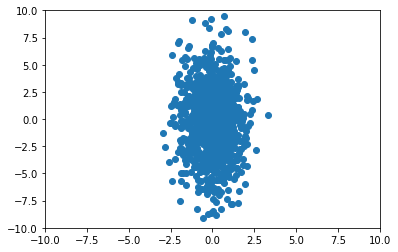

In [4]:
S = rng.multivariate_normal(m, c, 1000)
plt.scatter(S[:,0], S[:,1])
plt.xlim(-10,10)
plt.ylim(-10,10)

In [78]:
def mala_proposal(pi, gradLogPi, x0, tau):
    rng = np.random.default_rng()
    noise = jnp.array(rng.standard_normal(x0.shape))
    x1 = x0 + tau**2/2 * gradLogPi(x0) + tau * noise
    
    qx0x1_exparg = tau*noise
    qx1x0_exparg = x0 - x1 - tau**2/2 * gradLogPi(x1)
    q_ratio = jnp.exp(-1/(2*tau**2) * (l2sq(qx1x0_exparg) - l2sq(qx0x1_exparg)))
    h_ratio = pi(x1)/pi(x0)
    r = q_ratio * h_ratio
    
    return x1, r

In [71]:
pi = lambda x : jnp.exp(-1/2 * (x-m) @ c_inv @ (x-m)) / jnp.sqrt((2*jnp.pi)**k * jnp.linalg.det(c))
logPi = lambda x : jnp.log(pi(x))

In [72]:
logPi(jnp.array([0,0]))

DeviceArray(-2.98916961, dtype=float64)

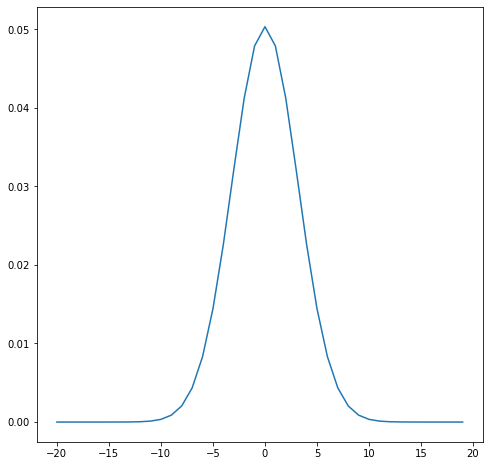

In [120]:
x = jnp.arange(-20,20)
y = [pi(jnp.array([0,xi])) for xi in x]
plt.plot(x,y)

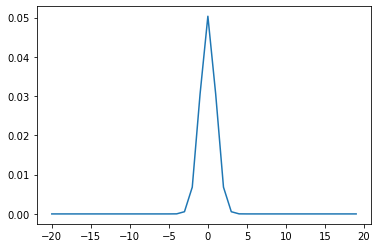

In [74]:
y2 = [pi(jnp.array([xi,0])) for xi in x]
plt.plot(x,y2)

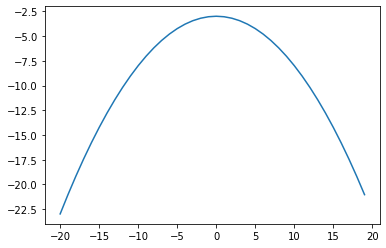

In [75]:
y3 = [logPi(jnp.array([0,xi])) for xi in x]
plt.plot(x,y3)

In [76]:
gradLogPi = jax.grad(logPi)
gradLogPi(jnp.array([0.,-5.]))

DeviceArray([0. , 0.5], dtype=float64)

In [138]:
#x0 = jnp.zeros(2)
x0 = jnp.array([20,0])
tau = 0.2
N = 1000

x1 = np.zeros([N, 2])
x1[0] = x0
rr = np.zeros(N)
for i in np.arange(1, x1.shape[0]):
    x1p, r = mala_proposal(pi, gradLogPi, x1[i-1], tau)
    a = jnp.minimum(1, r)
    rr[i] = a
    
    if np.random.rand() < a:
        x1[i] = x1p
    else:
        x1[i] = x1[i-1]

(-20.0, 20.0)

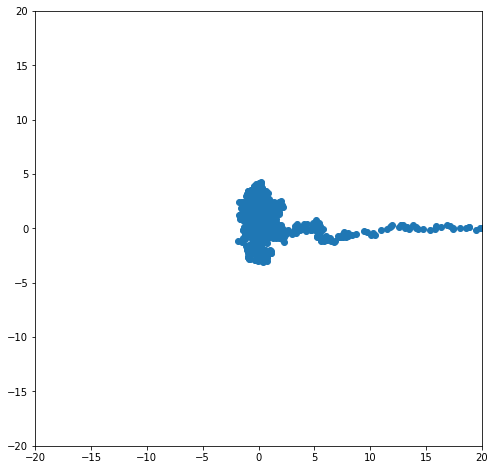

In [139]:
plt.scatter(x1[:,0], x1[:,1])
plt.xlim(-20,20)
plt.ylim(-20,20)

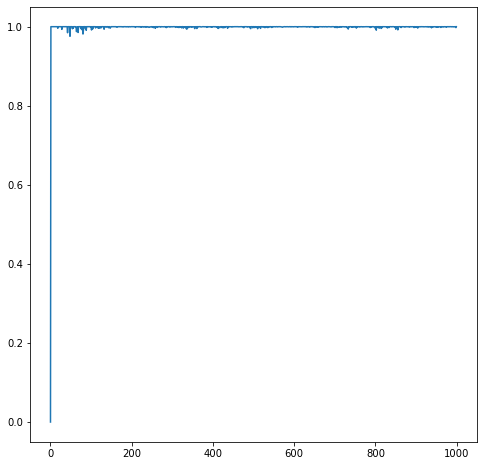

In [140]:
plt.plot(rr)